In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from matplotlib.ticker import StrMethodFormatter
from scipy import stats

In [10]:
transaction_data = pd.read_excel(r'C:\Users\BOSS\Desktop\DATA\python_folder\poject_1\QVI_transaction_data.xlsx')

DATE — Дата транзакції. Вказує на день, коли була здійснена покупка.  
STORE_NBR — Номер магазину. Унікальний ідентифікатор магазину, де була здійснена транзакція.  
LYLTY_CARD_NBR — Номер картки лояльності. Унікальний номер картки клієнта, зареєстрованого в програмі лояльності.  
TXN_ID — Ідентифікатор транзакції. Унікальний номер для кожної покупки, який дозволяє відслідковувати конкретну операцію.  
PROD_NBR — Номер продукту. Унікальний ідентифікатор товару, який був куплений.  
PROD_NAME — Назва продукту. Назва товару, який було куплено.  
PROD_QTY — Кількість продукту. Відображає кількість одиниць товару, яку купив клієнт.  
TOT_SALES — Загальна сума продажу. Вартість транзакції для купленого товару або декількох товарів.

In [11]:
#Виводимо типи даних 
transaction_data.info() 
#Відображаємо перші 5 рядків
transaction_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            264836 non-null  int64  
 1   STORE_NBR       264836 non-null  int64  
 2   LYLTY_CARD_NBR  264836 non-null  int64  
 3   TXN_ID          264836 non-null  int64  
 4   PROD_NBR        264836 non-null  int64  
 5   PROD_NAME       264836 non-null  object 
 6   PROD_QTY        264836 non-null  int64  
 7   TOT_SALES       264836 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 16.2+ MB


,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


 Стовпець 'DATE' має форамт int, його потрібно змінити на date

In [12]:

# Змінюємо тип даних в стовпці DATE на datetime
transaction_data['DATE']=pd.to_datetime(transaction_data['DATE'], unit='D', origin='1899-12-30')

Зробими базовий аналіз тексту, узагальнюючи окремі слова в назві товару, щоб переконатися що в нащопу наборі даних лише чіпси.

In [13]:

#Створюєм дата фрейм з унікальними словами з стовпця 'PROD_NAME'
unique_prod_name=transaction_data['PROD_NAME'].unique()
prod_word=list(set([word for prod_name in unique_prod_name for word in prod_name.split()]))
word_table= pd.DataFrame(prod_word, columns=['words'])

# Функція(маска), яка видаляє всі слова з цифрами та спеціальними символами
def contains_only_letters(w):
    return bool(re.match(r'^[A-Za-z]+$',w))

word_table=word_table[word_table['words'].apply(contains_only_letters)]

#Рахуєм кількість повторень кожного слова в 'PROD_NAME'
counts=transaction_data['PROD_NAME'].str.split(expand=True).stack().value_counts()
word_table['count']=word_table['words'].map(counts).fillna(0).astype(int)
#Переглянемо перші топ20 слів, які повторюються в наборі даних
word_table.sort_values('count', ascending=False).head(20)

,words,count
165,Chips,49770
128,Kettle,41288
170,Smiths,28860
204,Salt,27976
101,Cheese,27890
3,Pringles,25102
2,Doritos,24962
132,Crinkle,23960
18,Corn,22063
207,Original,21560


In [14]:
transaction_data['PROD_NAME'][transaction_data['PROD_NAME'].str.contains('Salsa')].unique()

array(['Old El Paso Salsa   Dip Tomato Mild 300g',
       'Red Rock Deli SR    Salsa & Mzzrlla 150g',
       'Smiths Crinkle Cut  Tomato Salsa 150g',
       'Doritos Salsa       Medium 300g',
       'Old El Paso Salsa   Dip Chnky Tom Ht300g',
       'Woolworths Mild     Salsa 300g',
       'Old El Paso Salsa   Dip Tomato Med 300g',
       'Woolworths Medium   Salsa 300g', 'Doritos Salsa Mild  300g'],
      dtype=object)

У наборі даних є продукти для сальси, але нас цікавлять лише чіпси категорію, тож видалімо їх.

In [15]:
#Список який мість назву продукту для сальси
salsa_prod = ['Old El Paso Salsa   Dip Tomato Mild 300g', 
              'Doritos Salsa       Medium 300g', 
              'Old El Paso Salsa   Dip Chnky Tom Ht300g', 
              'Woolworths Mild     Salsa 300g', 
              'Old El Paso Salsa   Dip Tomato Med 300g', 
              'Woolworths Medium   Salsa 300g', 
              'Doritos Salsa Mild  300g']
#Фільтруємо набір даних залишаємо тільки чіпси
transaction_data=transaction_data[~transaction_data['PROD_NAME'].isin(salsa_prod)]

In [16]:
# Переглянем загальну статистику
transaction_data.describe()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
count,249670,249670.000000,2.496700e+05,2.496700e+05,249670.000000,249670.000000,249670.000000
mean,2018-12-30 02:25:45.201265664,135.044278,1.355203e+05,1.351234e+05,56.294288,1.907762,7.293966
min,2018-07-01 00:00:00,1.000000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.700000
25%,2018-09-30 00:00:00,70.000000,7.001625e+04,6.757425e+04,27.000000,2.000000,5.700000
50%,2018-12-30 00:00:00,130.000000,1.303600e+05,1.351475e+05,53.000000,2.000000,7.400000
75%,2019-03-31 00:00:00,203.000000,2.030798e+05,2.026338e+05,86.000000,2.000000,8.800000
max,2019-06-30 00:00:00,272.000000,2.373711e+06,2.415841e+06,114.000000,200.000000,650.000000
std,NaN,76.773591,8.065746e+04,7.813155e+04,33.528758,0.657126,3.071796


PROD_QTY максималь 200 одиниць. Якщо поглянути на середнє значення 1.9  та стандартне відхилення 0.65. Можна припустити що це "викид".  
Розглянемо випадок, коли 200 пакети чіпсів купуються за одну операцію.

In [17]:
#Фільтруєм набір даних, щоб побачити викид
transaction_data[transaction_data['PROD_QTY']==200]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


Маємо дві транзакції і обидві ці транзакції були здійснені одним клієнтом.  
Поглянемо на інші транзакції цього клієнта.

In [18]:
transaction_data[transaction_data['LYLTY_CARD_NBR']==226000]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


Має лише дві транзакції від даного клієнта, що є не типовим для нашого набору даних. Тому вилумо їх з подальшого аналізу.

In [19]:
#Фільтруємо викиди в наборі даних.
transaction_data=transaction_data[transaction_data['LYLTY_CARD_NBR']!=226000]

In [20]:
# Перевіряємо пропущенні дати 
start = transaction_data['DATE'].min()
end = transaction_data['DATE'].max()
date_line= pd.date_range(start=start, end=end)
miss_date= date_line.difference(transaction_data['DATE'])
print(miss_date)


DatetimeIndex(['2018-12-25'], dtype='datetime64[ns]', freq=None)


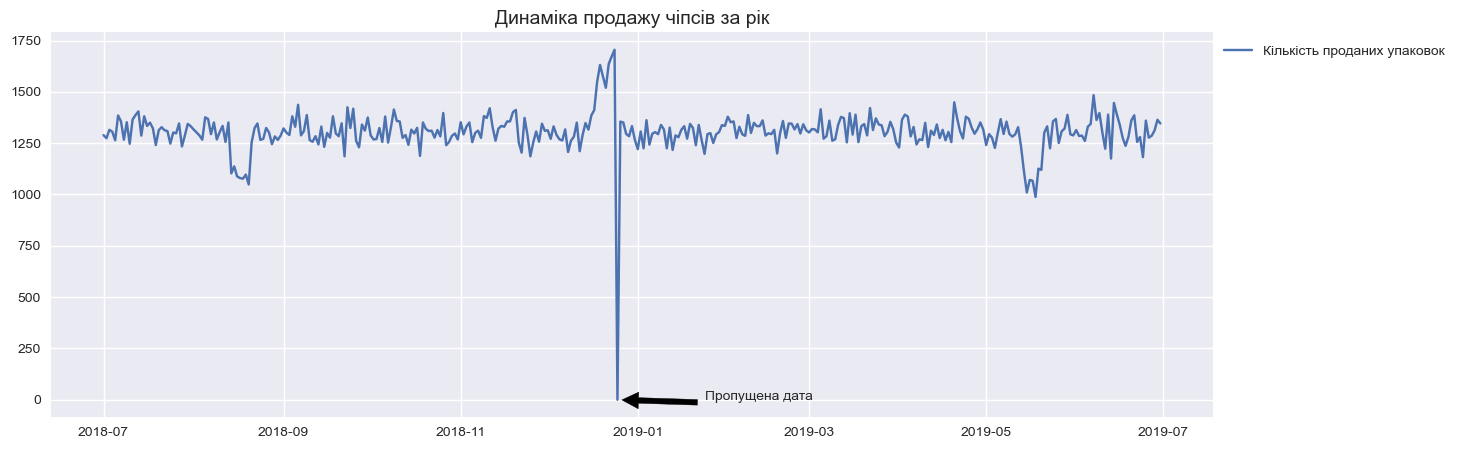

In [21]:
grouped = transaction_data[['DATE', 'PROD_QTY']].groupby('DATE').sum() #кількість проданих чіпсів кожного дня

#Додаєм пропущену дату та даємо значення "0"
grouped.loc[miss_date[0]]=[0]
grouped=grouped.sort_index()

#Будуємо графік
plt.style.use('seaborn-v0_8')
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(grouped, label='Кількість проданих упаковок')
plt.title('Динаміка продажу чіпсів за рік', size=14)
plt.legend(loc='upper right', bbox_to_anchor=(1.21, 1))
ax.annotate( 'Пропущена дата', xy=((miss_date[0]), 0), xytext=((miss_date[0])+pd.Timedelta(days=30), 1), arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()


Бачимо, що зростання продажів відбувається напередодні Різдва на сам день Різдва немає розпродажів. Можемо припустити, що це через закриття магазинів Різдвяний день.

In [22]:
transaction_data['PACKET_SIZE']=transaction_data['PROD_NAME'].str.extract(r'(\d+)').astype(int)

<Axes: ylabel='Frequency'>

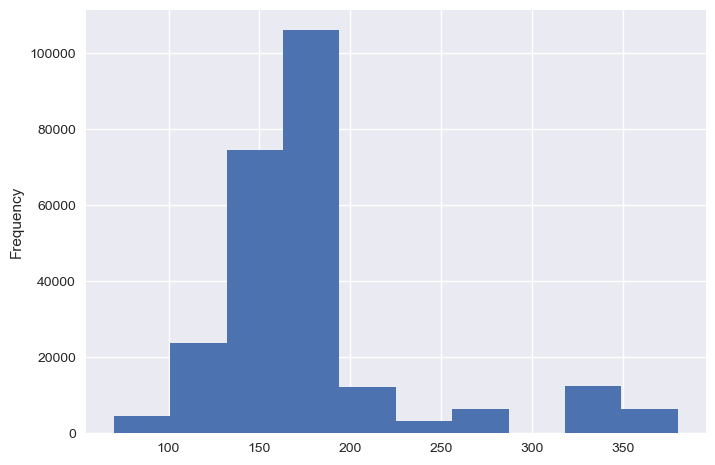

In [23]:
transaction_data['PACKET_SIZE'].plot(kind='hist')

In [24]:
#Відокремлюємо перше слово в назві товару як бренд
transaction_data['BRAND']=transaction_data['PROD_NAME'].str.extract(r'(\S+)')
#Замінюємо 'Red' ( Red Rock Deli) на RRD
transaction_data['BRAND']=transaction_data['BRAND'].str.replace('Red', 'RRD')
#Замінюємо 'WW' на  'Woolworths'
transaction_data['BRAND']=transaction_data['BRAND'].str.replace('WW', 'Woolworths')
#Замінюємо 'Natural' (Natural Chip Compny) на 'NCC'
transaction_data['BRAND']=transaction_data['BRAND'].str.replace('Natural', 'NCC')
#Замінюємо 'Smith'  на 'Smiths'
transaction_data['BRAND']=transaction_data['BRAND'].str.replace(r'(\bSmith\b)', 'Smiths', regex= True)
#Замінюємо  'Snbts ' на 'Sunbites'
transaction_data['BRAND']=transaction_data['BRAND'].str.replace('Snbts ', 'Sunbites')

In [25]:
transaction_data['BRAND'].sort_values().drop_duplicates().index

Index([ 44232,  16960,  12090,  30869,  58533,  57338,  95976,  70327,  57813,
       132263,  14834,  86087, 150651, 140970, 256130,  53421, 196335, 259703,
       186145, 224992, 138859, 200172, 156961, 174716],
      dtype='int64')

In [26]:
transaction_data[transaction_data['PROD_NAME'].str.contains('Thins')]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACKET_SIZE,BRAND
14,2019-05-15,19,19272,16686,44,Thins Chips Light& Tangy 175g,1,3.3,175,Thins
33,2019-05-18,45,45220,41651,22,Thins Chips Originl saltd 175g,1,3.3,175,Thins
38,2018-08-18,54,54305,48301,44,Thins Chips Light& Tangy 175g,2,6.6,175,Thins
52,2019-05-20,71,71122,69717,40,Thins Chips Seasonedchicken 175g,1,3.3,175,Thins
97,2018-08-16,128,128231,132121,28,Thins Potato Chips Hot & Spicy 175g,1,3.3,175,Thins
...,...,...,...,...,...,...,...,...,...,...
264735,2019-04-04,267,267345,264377,78,Thins Chips Salt & Vinegar 175g,1,3.3,175,Thins
264765,2019-04-10,269,269133,265837,44,Thins Chips Light& Tangy 175g,2,6.6,175,Thins
264770,2019-03-02,269,269203,266265,28,Thins Potato Chips Hot & Spicy 175g,2,6.6,175,Thins
264785,2018-09-14,270,270002,266606,78,Thins Chips Salt & Vinegar 175g,2,6.6,175,Thins


In [27]:
customer=pd.read_csv(r'C:\Users\BOSS\Desktop\DATA\python_folder\poject_1\QVI_purchase_behaviour.csv')

In [28]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72637 entries, 0 to 72636
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LYLTY_CARD_NBR    72637 non-null  int64 
 1   LIFESTAGE         72637 non-null  object
 2   PREMIUM_CUSTOMER  72637 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [29]:
df=pd.merge(transaction_data, customer , on='LYLTY_CARD_NBR', how='left')
# Перевірка на наявність порожніх значень після об'єднання
print(df.isnull().sum())

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249668 entries, 0 to 249667
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   DATE              249668 non-null  datetime64[ns]
 1   STORE_NBR         249668 non-null  int64         
 2   LYLTY_CARD_NBR    249668 non-null  int64         
 3   TXN_ID            249668 non-null  int64         
 4   PROD_NBR          249668 non-null  int64         
 5   PROD_NAME         249668 non-null  object        
 6   PROD_QTY          249668 non-null  int64         
 7   TOT_SALES         249668 non-null  float64       
 8   PACKET_SIZE       249668 non-null  int32         
 9   BRAND             249668 non-null  object        
 10  LIFESTAGE         249668 non-null  object        
 11  PREMIUM_CUSTOMER  249668 non-null  object        
dtypes: datetime64[ns](1), float64(1), int32(1), int64(5), object(4)
memory usage: 21.9+ MB


In [31]:
# Збереження df( transaction_data + customer)
# df.to_csv(r'C:\Users\BOSS\Desktop\DATA\python_folder\poject_1\QVI_data.csv')

- Хто найбільше витрачає на чіпси (загальний обсяг продажів), опис клієнтів за життєвими етапами та наскільки преміальною є їхня загальна купівельна поведінка?  
- Скільки клієнтів у кожному сегменті?  
- Скільки чіпсів купується на одного клієнта за сегментами?  
- Яка середня ціна чіпів за сегментами клієнтів?

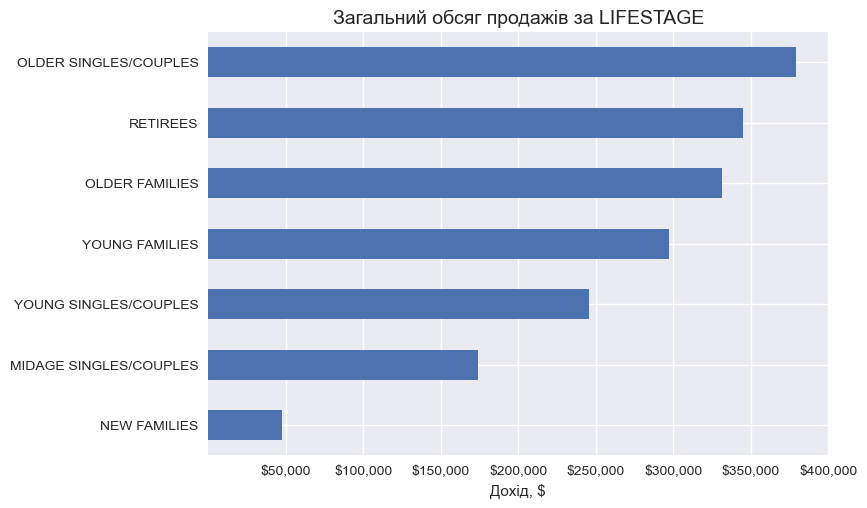

In [32]:
ax=df.groupby('LIFESTAGE')['TOT_SALES'].sum().sort_values().plot(kind='barh')
plt.title('Загальний обсяг продажів за LIFESTAGE', size=14)
plt.ylabel('')
plt.xlabel('Дохід, $')
ax.xaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
ax.set_xticks(ax.get_xticks()[1:])
plt.show()

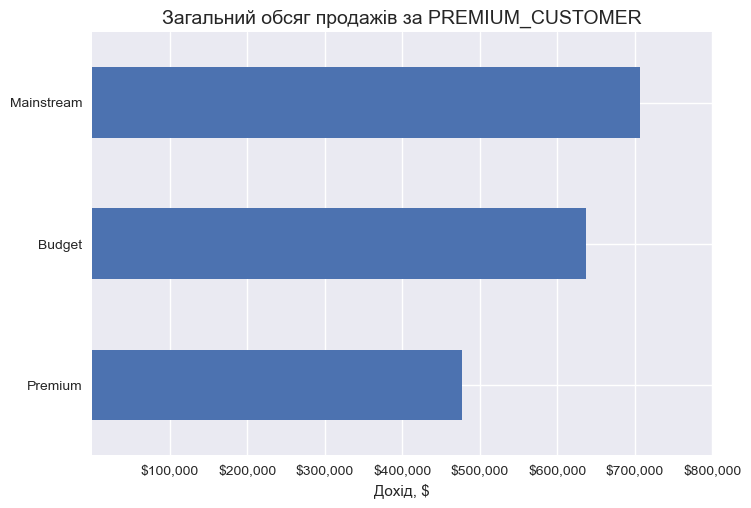

In [33]:
ax=df.groupby('PREMIUM_CUSTOMER')['TOT_SALES'].sum().sort_values().plot(kind='barh')
plt.title('Загальний обсяг продажів за PREMIUM_CUSTOMER', size=14)
plt.ylabel('')
plt.xlabel('Дохід, $')
ax.xaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
ax.set_xticks(ax.get_xticks()[1:])
plt.show()

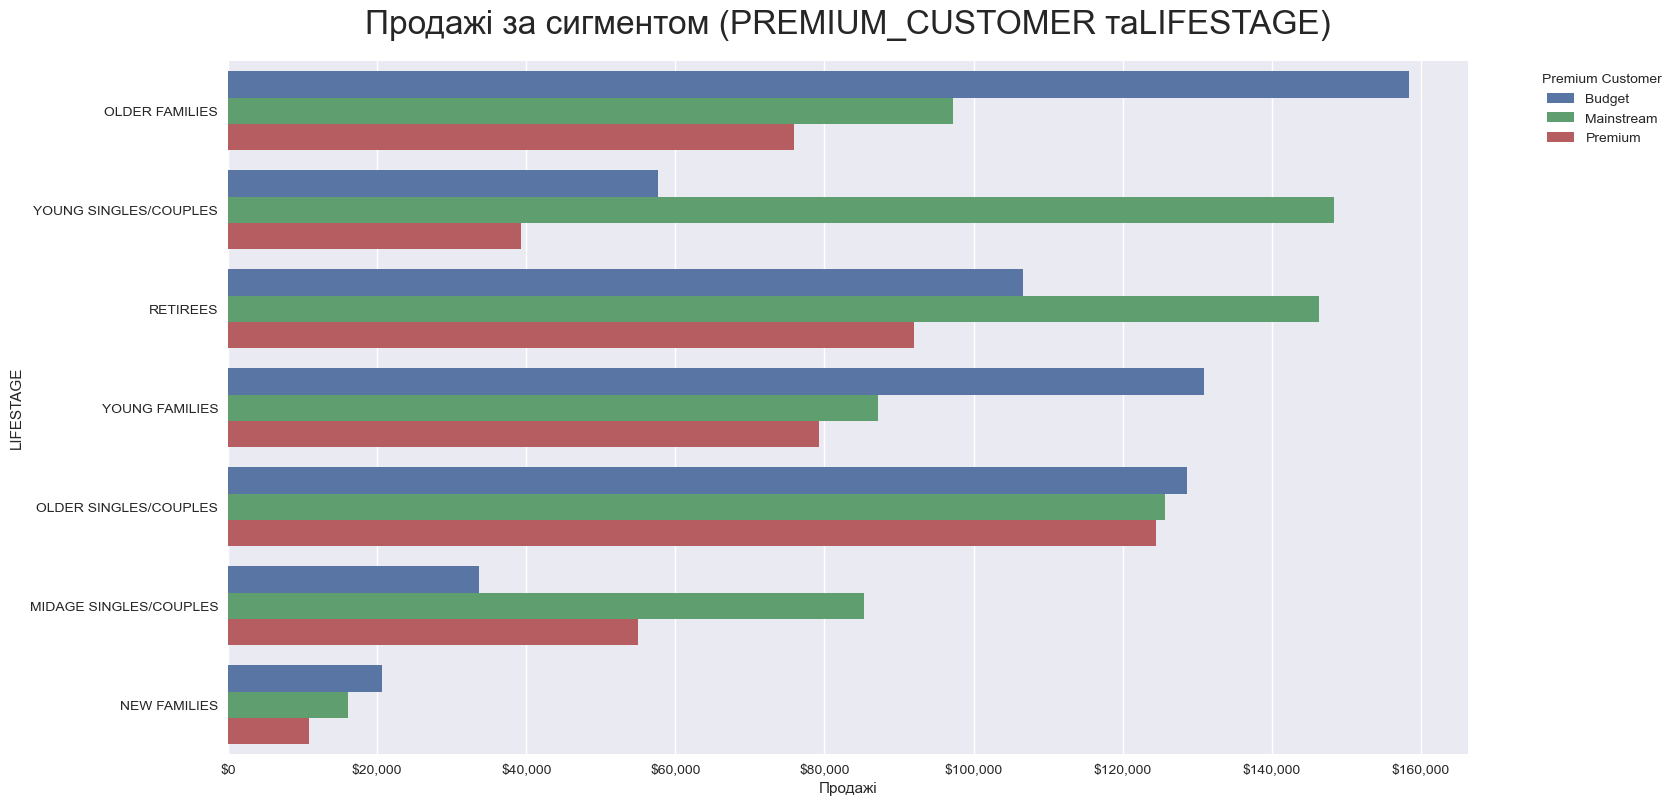

In [64]:
#Групуван даних
grouped_df=df.groupby(['PREMIUM_CUSTOMER', 'LIFESTAGE'])['TOT_SALES'].sum().reset_index().sort_values(by='TOT_SALES', ascending=False)

# Створення графіка
plt.figure(figsize=(16, 9))
g=sns.barplot(data=grouped_df, y='LIFESTAGE', x='TOT_SALES', hue='PREMIUM_CUSTOMER')

# Налаштування графіка
plt.title('Продажі за сигментом (PREMIUM_CUSTOMER таLIFESTAGE)', size=24, pad=20)
plt.xlabel('Продажі')
plt.ylabel('LIFESTAGE')
plt.legend(title='Premium Customer', bbox_to_anchor=(1.05, 1), loc='upper left')  # Позиція легенди
g.xaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))
plt.show()

Продажі надходять в основному від Budget - older families, Mainstream - young singles/couples, та Mainstream - retirees.


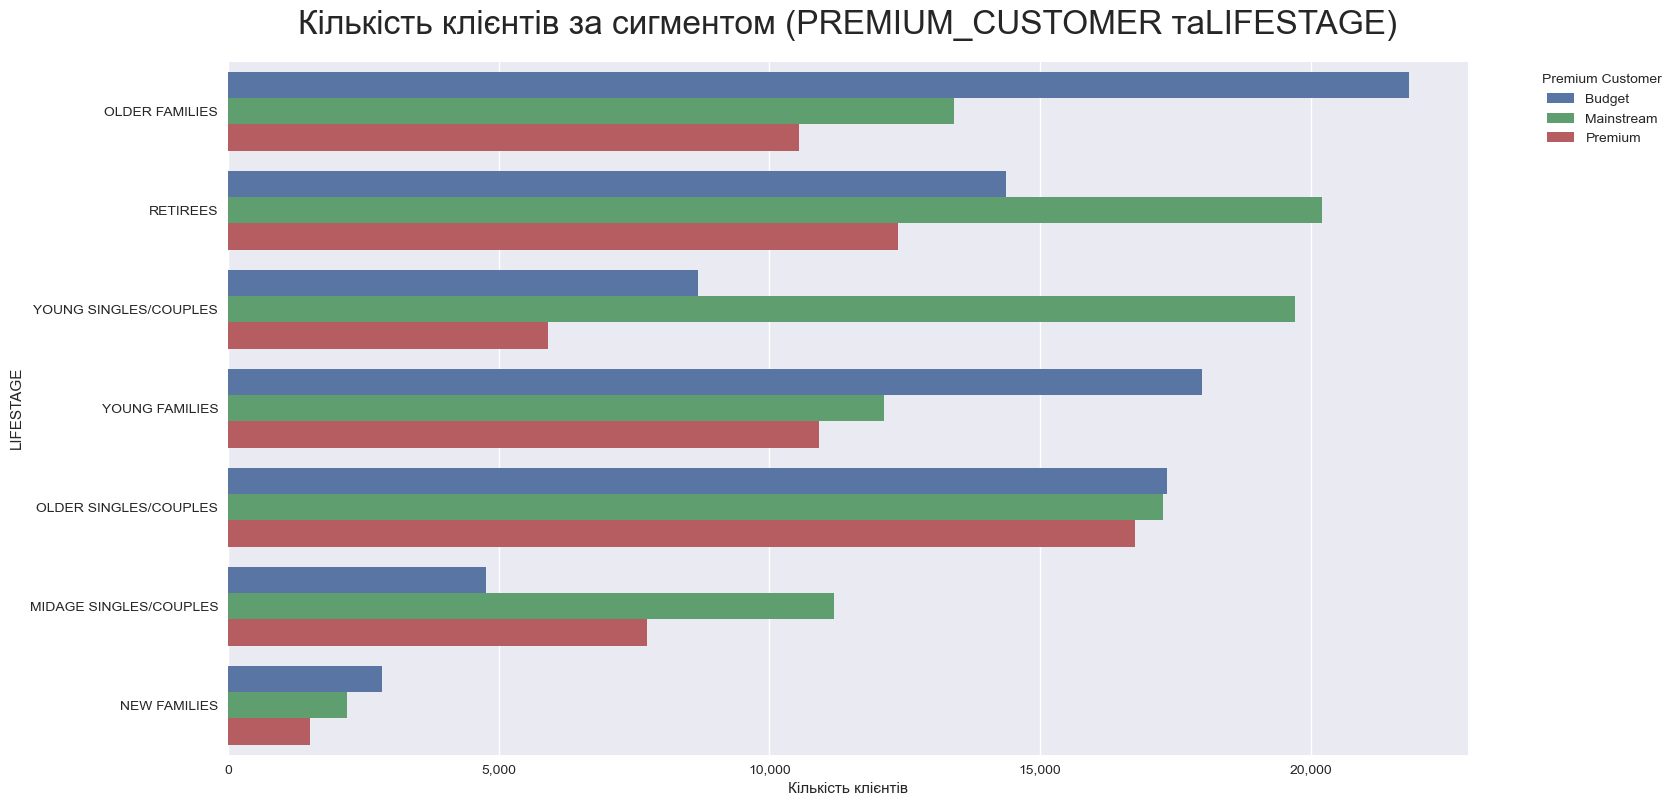

In [71]:
# Групування даних
customer_group_count=df.groupby(['PREMIUM_CUSTOMER', 'LIFESTAGE'])['LYLTY_CARD_NBR'].count().reset_index().sort_values(by='LYLTY_CARD_NBR', ascending=False)

# Побудова графіка
plt.figure(figsize=(16,9))
g=sns.barplot(data= customer_group_count, y='LIFESTAGE', x='LYLTY_CARD_NBR', hue='PREMIUM_CUSTOMER')

# Налаштування графіка
plt.title('Кількість клієнтів за сигментом (PREMIUM_CUSTOMER таLIFESTAGE)', size=24, pad=20)
plt.xlabel('Кількість клієнтів')
plt.ylabel('LIFESTAGE')
plt.legend(title='Premium Customer', bbox_to_anchor=(1.05, 1), loc='upper left')
g.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.show()

Перевіремо скільки в середньому купують упаковок чіпсів з сегментом покупця.

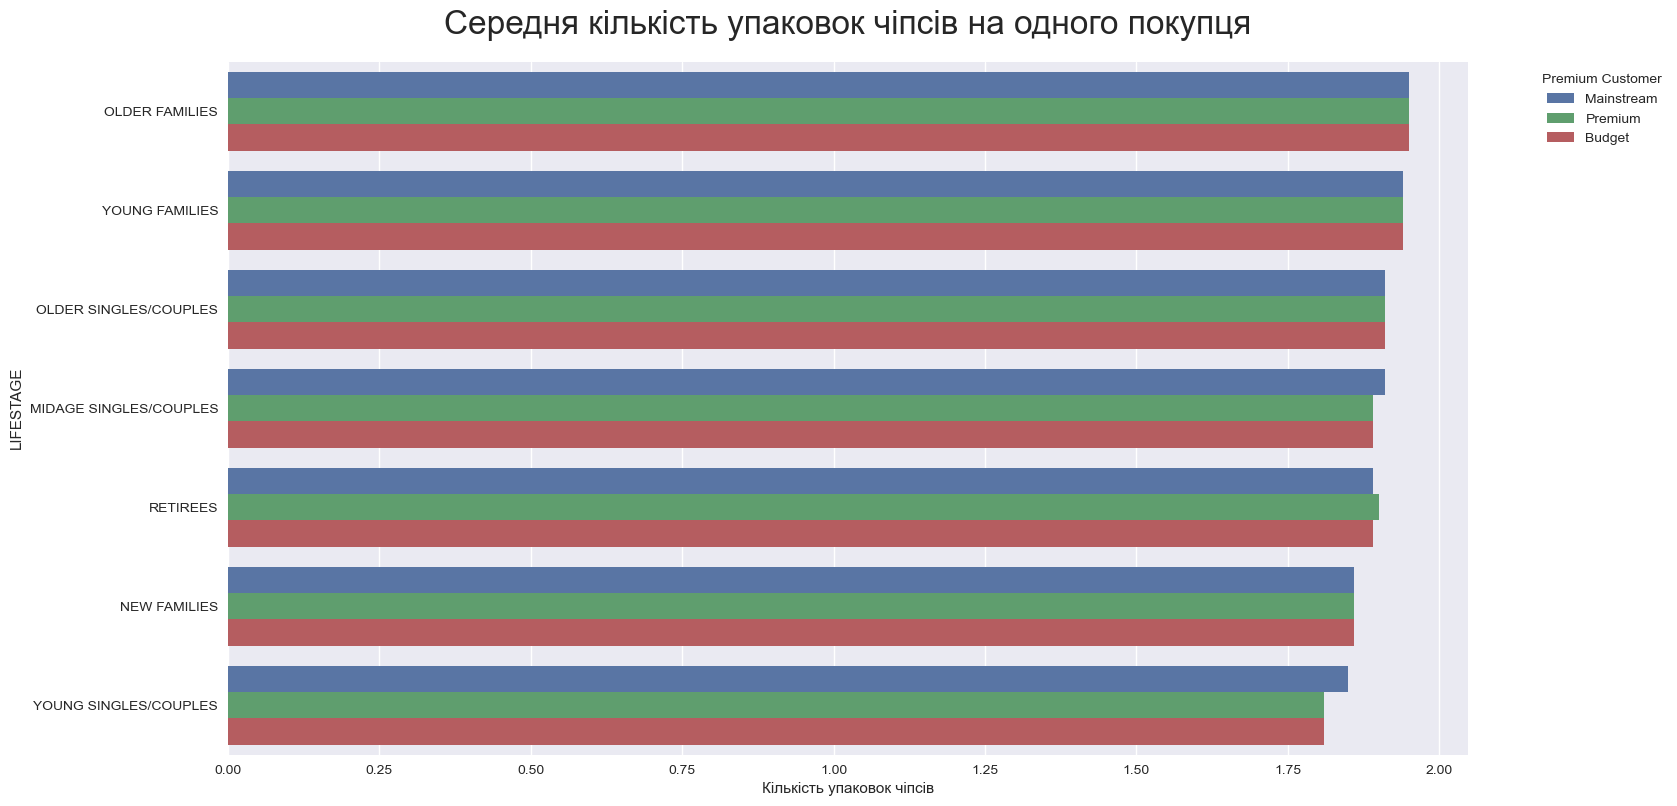

In [82]:
# Групування даних
customer_group_avg=df.groupby(['PREMIUM_CUSTOMER', 'LIFESTAGE'])['PROD_QTY'].mean().reset_index().sort_values(by='PROD_QTY', ascending=False)
customer_group_avg['PROD_QTY']=customer_group_avg['PROD_QTY'].round(2)

# Побудова графіка
plt.figure(figsize=(16,9))
g=sns.barplot(data= customer_group_avg, y='LIFESTAGE', x='PROD_QTY', hue='PREMIUM_CUSTOMER')

# Налаштування графіка
plt.title('Середня кількість упаковок чіпсів на одного покупця', size=24, pad=20)
plt.xlabel('Кількість упаковок чіпсів')
plt.ylabel('LIFESTAGE')
plt.legend(title='Premium Customer', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Older families та young families купують найбільше чіпсів

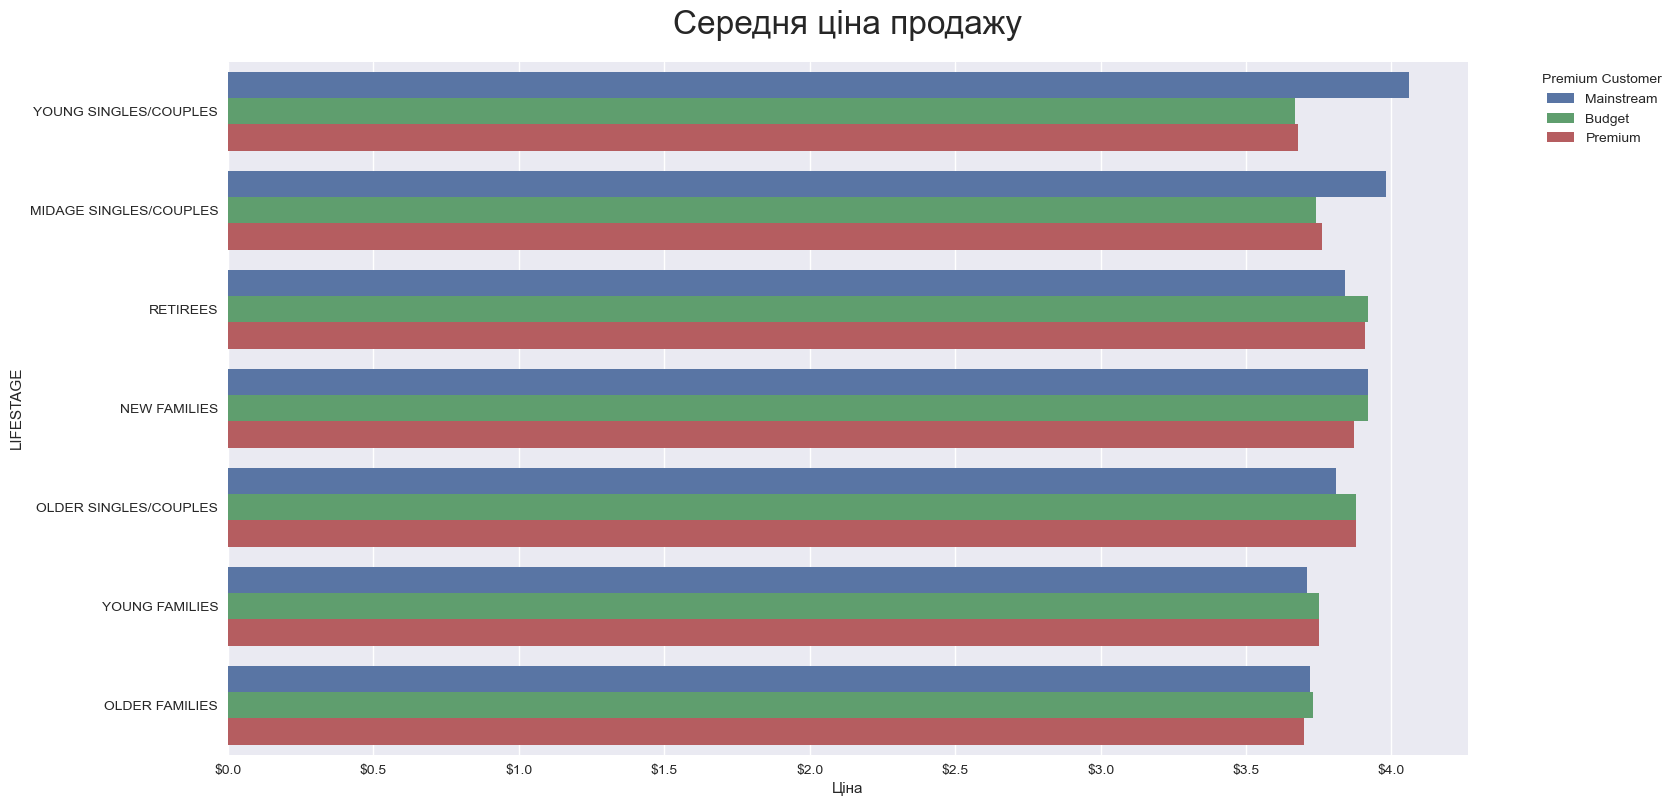

In [102]:
# Групування данихю
price_group=df.groupby(['PREMIUM_CUSTOMER', 'LIFESTAGE'])[['TOT_SALES','PROD_QTY']].sum()
price_group['AVG_Price']= (price_group['TOT_SALES']/price_group['PROD_QTY']).round(2) # Середня ціна продажу
price_group=price_group.reset_index().sort_values(by='AVG_Price', ascending=False)

# Побудова графіка
plt.figure(figsize=(16,9))
g=sns.barplot(data= price_group, y='LIFESTAGE', x='AVG_Price', hue='PREMIUM_CUSTOMER')

# Налаштування графіка
plt.title('Середня ціна продажу', size=24, pad=20)
plt.xlabel('Ціна')
plt.ylabel('LIFESTAGE')
plt.legend(title='Premium Customer', bbox_to_anchor=(1.05, 1), loc='upper left')
g.xaxis.set_major_formatter(StrMethodFormatter('${x:.1f}'))
plt.show()


# t-test

In [131]:
df['SALES_PER_QTY']= (df['TOT_SALES']/df['PROD_QTY']).round(2)
#гурпа 1 Mainstream Young Singles/Couples + Mainstream Midage Singles/Cuopeles 
group_1=df[(df['PREMIUM_CUSTOMER'] == 'Mainstream') & (df['LIFESTAGE'].isin(['YOUNG SINGLES/COUPLES', 'MIDAGE SINGLES/COUPLES']))]['SALES_PER_QTY']

# група 2  Premium Singles/Couples і  Midage Singles/Cuopeles  + Budget Young Singles/Couples і  Midage Singles/Cuopeles 
group_2=df[(df['PREMIUM_CUSTOMER'].isin(['Premium', 'Budget'])) & (df['LIFESTAGE'].isin(['YOUNG SINGLES/COUPLES', 'MIDAGE SINGLES/COUPLES']))]['SALES_PER_QTY']

# Обчислення t та р
t_stat, p_value = stats.ttest_ind(group_1,group_2)
# Резултат
print(f"T-статистика : {t_stat}, P-значення: {p_value}")

T-статистика : 38.30184898792326, P-значення: 0.0


Інтерпретація результатів t-тесту: 
T-статистика: 38.30 — це велике значення t-статистики, яке показує, що середні значення двох груп мають велику різницю.  
P-значення: 0.0 — це надзвичайно мале значення, що фактично означає, що ймовірність того, що така різниця між групами виникла випадково, практично нульова.  
Висновок:  
Оскільки p-значення значно менше стандартного рівня значущості (0.05 або 0.01), ми відхиляємо нульову гіпотезу.  
Це означає, що різниця між середніми значеннями вибірок (наприклад, "Mainstream" і "Premium" або інші групи, які ви порівнювали) є статистично значущою. Інакше кажучи, ці групи дійсно відрізняються за показником SALES_PER_QTY.  
Дані підтверджують, що різниця між двома групами є реальною і не випадковою.